# Demonstrate Joint UKF Estimation

In [1]:
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from asoh.models.ecm.advancedSOH import ECMASOH
from asoh.models.ecm.ins_outs import ECMInput
from asoh.estimators.online.joint.ecm.unscented import ECMJointUKF, ECMJointUKFInterface

First, let's define a random number generator for consistency.

In [2]:
# Initialize RNG
rng = np.random.default_rng(seed=1001001)

In this example, we will start by establishing a cycling protocol which assumes every cycle starts with the cell at 100%
SOC. This protocol follows the procedure below: 
1. rest the cell for 5-10 minutes
2. discharge the cell at a C-rate between 1.5 and 2.5 C
3. rest the cell for 10-20 minutes
4. charge the cell at a C-rate between 0.5 and 1.5 C
5. rest the cell for 5-10 minutes

We will create a helper function to specify timestamps and currents for a given cycle. These will be reported at 
approximately every second. 

In [3]:

def cycle_protocol(asoh: ECMASOH, start_time:float = 0.0) -> List[ECMInput]:
    """
    Function to return list of ECMInputs corresponding to a new cycle

    Args: 
        asoh: A-SOH object to be used
        start_time: time at which to start this cycle in seconds
    
    Returns:
        ecm_inputs: list of ECMInput objects corresponding to this cycle
    """
    # initialize main lists to be used
    timestamps = []
    currents = []

    # Get the Qt and CE, which will help determine the currents
    qt = asoh.q_t.amp_hour
    ce = asoh.ce

    # Now, let's choose rest durations and C-rates
    rest0, rest1, rest2 = rng.integers(low=5, high=10, size=3)
    rest0 *= 60
    rest1 *= 2 * 60
    rest2 *= 60
    dischg_rate, chg_rate = np.array([1.5, 0.5]) + rng.random(size=2)

    def update_timestamps_curr(duration: float, curr: float) -> None:
        """
        Helper to populate timestamps and currents.

        Args:
            duration: duration of segment in seconds
            curr: value of current to be used. 
        """
        # specify binds to nearest variables 
        nonlocal currents
        nonlocal timestamps
        new_len = int(np.ceil(duration))
        currents += [curr] * new_len
        new_times = np.sort(rng.random(size=new_len)) * duration
        if len(timestamps) == 0:
            new_times += start_time
        else:
            new_times += timestamps[-1] + (1.0e-03)
        timestamps += new_times.tolist()

    # Rest 0
    update_timestamps_curr(duration=rest0, curr=0.0)

    # Discharge
    dischg_duration = 3600.0 / dischg_rate
    dischg_curr = -(qt * dischg_rate)
    update_timestamps_curr(duration=dischg_duration, curr=dischg_curr)

    # Rest 1
    update_timestamps_curr(duration=rest1, curr=0.0)

    # Charge
    chg_duration = 3600.0 / chg_rate
    chg_curr = (qt * dischg_rate) / ce
    update_timestamps_curr(duration=chg_duration, curr=chg_curr)

    # Rest 2
    update_timestamps_curr(duration=rest2, curr=0.0)

    # Finally, assemble the ECMInputs
    ecm_inputs = [ECMInput(time=time, current=current) for time, current in zip(timestamps, currents)]
    return ecm_inputs

For this example, we will look at a single RC element Thenevin model. Only the series resistance $R_0$ and OCV will be 
functions of SOC. We will assume the R0 follows a quadratic profile with SOC, with the values increasing as SOC approaches
0% or 100%. 

We will maintain the OCV fixed, and allow the maximum theoretical discharge capacity $Q_t$, the coulombic efficiency CE, the series resistant $R_0$, and RC components to change with cycling. More 
specifically, we will assume that they are all constant within a cycle, but will degrade from cycle to cycle in the 
following manner:
1. $Q_t$ will go down by a factor of 0.05% with each new cycle: $\left(Q_{t, k+1} = 0.9995 Q_{t,k}\right)$
2. the CE will decrease linearly by 0.005% at every cycle 
3. $R_0$ will increase linearly by $1.0\times10^{-6}\Omega$ at every new cycle
4. the resistance of the RC resistor will go up by a factor of 0.01% at every cycle: 
$R_{RC_1, k+1} = 1.0001 * R_{RC_1,k}$
5. the capacitance of the RC capacitor will got down by a factor of 0.001% at every cycle: 
$c_{RC_1, k+1} = 0.99999 * C_{RC_1,k}$

In [4]:
# Function to help with A-SOH degradation established above
def degrade_asoh(asoh: ECMASOH,
                 qt_deg_factor: float = 0.0005,
                 ce_deg_factor: float = 0.005,
                 r0_deg_factor: float = 1.0e-06,
                 r_rc_deg_factor: float = 0.0001,
                 c_rc_deg_factor: float = 0.00001) -> ECMASOH:
    asoh_deg = asoh.model_copy(deep=True)
    # Calculate new values
    qt_deg = (1 - qt_deg_factor) * asoh_deg.q_t.base_values
    ce_deg = asoh_deg.ce - ce_deg_factor
    r0_deg = asoh_deg.r0.base_values + r0_deg_factor
    r_rc_deg = (1 + r_rc_deg_factor) * asoh_deg.rc_elements[0].r.base_values
    c_rc_deg = (1 - c_rc_deg_factor) * asoh_deg.rc_elements[0].c.base_values
    # Set new values
    asoh_deg.q_t.base_values = qt_deg
    asoh_deg.ce = ce_deg
    asoh_deg.r0.base_values = r0_deg
    asoh_deg.rc_elements[0].r.base_values = r_rc_deg
    asoh_deg.rc_elements[0].c.base_values = c_rc_deg
    return asoh_deg

Let's define the Beginning of Life (BOL) A-SOH.

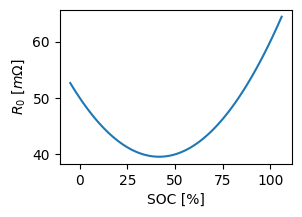

In [5]:
# Define the values of R0 to use
r0_vals = np.array([5,4,6]) * 1.0e-02

# Get A-SOH and set R0 values and interpolation style
asoh_bol = ECMASOH.provide_template(has_C0=False, num_RC=1, R0=r0_vals)
asoh_bol.r0.interpolation_style = 'quadratic'

# Check R0 profile
test_socs = np.arange(-0.05, 1.06, 0.01)
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(100 * test_socs, 1000 * asoh_bol.r0.get_value(soc=test_socs))
ax.set_xlabel('SOC [%]')
_ = ax.set_ylabel(r'$R_0$ $[m\Omega]$')

Now, let's start preparations for the co-simulation of this cell alongside its joint estimation.

First, let us create a new A-SOH ground truth object with the proper updatable parameters set to help with the simulator and joint estimator. 

In [9]:
asoh_gt = asoh_bol.model_copy(deep=True)
# Check that nothing is updatable yet:
print('Initial updatable parameters: ', asoh_gt.get_parameters())
asoh_gt.mark_updatable(name='q_t.base_values')
asoh_gt.mark_updatable(name='ce')
asoh_gt.mark_updatable(name='r0.base_values')
asoh_gt.mark_updatable(name='rc_elements.0.r.base_values')
asoh_gt.mark_updatable(name='rc_elements.0.c.base_values')
asoh_gt.mark_updatable(name='h0.base_values')
# Make sure we have all that is updatable
print('New updatable parameters: ', asoh_gt.get_parameters())

Initial updatable parameters:  []
New updatable parameters:  [10.0, 1.0, np.float64(0.05), np.float64(0.04), np.float64(0.06), 0.01, 2500.0, 0.05]


In [52]:
chain, what = asoh_gt._get_model_chain(name='rc_elements.0.r.base_values')
what[1]

RCComponent(updatable={'c', 'r'}, r=Resistance(updatable={'base_values'}, base_values=0.01, soc_pinpoints=None, interpolation_style='linear', reference_temperature=25, temperature_dependence_factor=0.0025), c=Capacitance(updatable={'base_values'}, base_values=2500.0, soc_pinpoints=None, interpolation_style='linear'))